# Graphs and Mazes

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
from collections import OrderedDict, deque, defaultdict, namedtuple
from itertools import product
from math import sqrt, pi, sin, cos
from random import random, randint, choice
import os
from IPython.display import display, clear_output, Image, HTML
import ipywidgets as widgets
import numpy as np
import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from drawing import VectorImage

-----

# A) Number Maze

To say if there is a unique shortest solution, we use a modification of BFS that explores by whole layers of positions in the same depth instead of by a single position and for each postion, we remember all its parents (on the shortest path from the start). If any position on a shortest path between the start and the goal has multiple parents, then the solution is not unique.

In [75]:
def solve_number_maze(maze, print_results=True):
    maze = np.matrix(maze)
    dirs = list(map(np.array, [(1, 0), (0, 1), (-1, 0), (0, -1)]))
    start = (0, 0)
    goal = (maze.shape[0] - 1, maze.shape[1] - 1)
    # As we process whole layers, we can use a list to store the queue.
    queue = [start]
    # For each position we store all of its parents on a shortest path.
    parents = defaultdict(list)
    parents[start] = [None]
    solution = None
    while queue and not solution:
        next_layer = []
        # Freeze previously seen positions.
        seen = set(parents.keys())
        for pos in queue:
            for direction in dirs:
                next_pos = get_next_pos(maze, pos, direction)
                if not next_pos or next_pos in seen:
                    continue
                next_layer.append(next_pos)
                parents[next_pos].append(pos)
        if goal in next_layer:
            solution, unique = get_path(goal, parents, ret_unique=True)
        queue = next_layer
    if print_results:
        print('Solution:', solution)
        print('Unique:', unique)
    else:
        return solution, unique

def get_next_pos(maze, pos, direction):
    length = maze[pos]
    next_pos = length * direction + pos
    if any(next_pos < (0, 0)) or any(next_pos >= maze.shape):
        return None  # out of the maze
    return tuple(next_pos)

def get_path(pos, parents, ret_unique=False):
    backpath = []
    unique = True
    while pos:
        backpath.append(pos)
        unique = unique and len(parents[pos]) == 1
        pos = parents[pos][0]
    path = list(reversed(backpath))
    return path, unique if ret_unique else path

solve_number_maze(
    [[2, 4, 4, 3, 3],
     [2, 3, 3, 2, 3],
     [3, 2, 3, 1, 3],
     [2, 2, 3, 2, 1],
     [1, 4, 4, 4, 0]])

Solution: [(0, 0), (2, 0), (2, 3), (1, 3), (1, 1), (1, 4), (4, 4)]
Unique: True


In [79]:
solve_number_maze([[1, 1], [1, 0]])

Solution: [(0, 0), (1, 0), (1, 1)]
Unique: False


In [77]:
solve_number_maze(
    [[3, 4, 3, 2, 2],
     [4, 4, 2, 2, 4],
     [4, 3, 1, 4, 2],
     [2, 1, 1, 3, 3],
     [1, 4, 2, 3, 0]])

Solution: [(0, 0), (3, 0), (3, 2), (4, 2), (4, 4)]
Unique: True


In [78]:
solve_number_maze(
    [[1, 4, 2, 1, 1],
     [2, 4, 2, 3, 2],
     [2, 3, 4, 2, 4],
     [3, 3, 3, 3, 2],
     [2, 4, 2, 2, 0]])

Solution: [(0, 0), (1, 0), (3, 0), (3, 3), (0, 3), (1, 3), (4, 3), (2, 3), (2, 1), (2, 4), (2, 0), (4, 0), (4, 2), (4, 4)]
Unique: True


To check if my BFS implementation (uniqueness decision) is correct, I compared the results a brute force solution to the problem:

In [86]:
def brute_force_number_maze(maze):
    maze = np.matrix(maze)
    dirs = list(map(np.array, [(1, 0), (0, 1), (-1, 0), (0, -1)]))
    goal = (maze.shape[0] - 1, maze.shape[1] - 1)
    solutions = []
    for length in range(1, maze.shape[0] * maze.shape[1]):
        for path_dirs in product(dirs, repeat=length):
            path = create_path(maze, path_dirs)
            if path and path[-1] == goal:
                solutions.append(path)
        if solutions:
            return solutions

def create_path(maze, dirs):
    path = [(0, 0)]
    for direction in dirs:
        next_pos = get_next_pos(maze, path[-1], direction)
        if not next_pos:
            return None
        path.append(next_pos)
    return path
                
brute_force_number_maze(
    [[3, 4, 3, 2, 2],
     [4, 4, 2, 2, 4],
     [4, 3, 1, 4, 2],
     [2, 1, 1, 3, 3],
     [1, 4, 2, 3, 0]])

[[(0, 0), (3, 0), (3, 2), (4, 2), (4, 4)]]

## B: Quantum Maze

Goal: get from the bottom-left to the top-right corner. Representation of states: current position and set of walls. In the solution visualization we use gradually increasing alpha to show the history of states and walls.

In [38]:
State = namedtuple('State', ['pos', 'walls', 'size'])

def draw_state(state, im=None, clear=True, linewidth=3, **kwargs):
    if im and clear:
        im.clear()
    im = im or VectorImage(axis=True)
    n = state.size
    corners = [(0, 0), (0, n), (n, n), (n, 0)]
    for i in range(4):
        im.line(corners[i], corners[(i+1)%4], linewidth=linewidth, **kwargs)
    im.lines(state.walls, linewidth=linewidth, **kwargs)
    im.point(get_real_position(state), color='c', markersize=15, **kwargs)
    plt.xticks(range(state.size+1))
    plt.yticks(range(state.size+1))
    return im
    
def get_real_position(state):
    return np.array([0.5, 0.5]) + state.pos

def draw_solution(states, im=None, linewidth=3):
    im = draw_state(states[0])
    for i, state in enumerate(states[1:], start=1):
        alpha = 0.3 + 0.7 * (i+1) / len(states)
        prev_state = states[i-1]
        start = get_real_position(prev_state)
        end = get_real_position(state)
        im.line(start, end, color='c', linewidth=15, alpha=alpha)
        # Draw only new walls.
        walls = set(state.walls) - set(prev_state.walls)
        im.lines(walls, linewidth=linewidth, alpha=alpha)
        
# s1 = State(pos=(0,0), size=5, walls=())
# s2 = State(pos=(1,0), size=5, walls=(((0,1), (1,1)),))
# s3 = State(pos=(1,1), size=5, walls=(((0,1), (1,1)), ((1,1), (1,2))))
# draw_state(s3)
# draw_solution([s1, s2, s3])

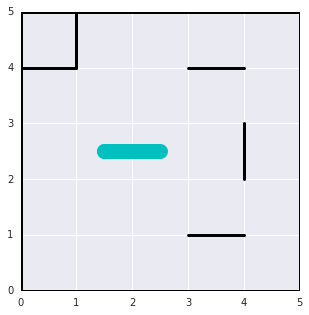

In [39]:
def create_next_state(state, direction):
    pos = move(state, direction)
    if not pos:
        return None
    walls = add_walls(state, direction)   
    return State(pos=pos, walls=walls, size=state.size)

def move(state, direction):
    p, d, dl, dr = expand_direction(state, direction)
    crossed_edge = normalize((p - 0.5*d + 0.5*dl, p - 0.5*d + 0.5*dr))
    return discretize(p) if crossed_edge not in state.walls else None

def discretize(real_position):
    return tuple(map(int, real_position))

def add_walls(state, direction):
    p, d, dl, dr = expand_direction(state, direction)
    front_wall = (p + 1.5*d + 0.5*dl, p + 1.5*d + 0.5*dr)
    left_wall = (p + 0.5*d + 1.5*dl, p + 1.5*d + 1.5*dl)
    right_wall = (p + 0.5*d + 1.5*dr, p + 1.5*d + 1.5*dr)
    walls = set(state.walls + tuple(
        normalize(wall) for wall in [front_wall, left_wall, right_wall]
        if is_wall_in_maze(wall, state.size)))
    return tuple(sorted(walls))

def expand_direction(state, direction):
    """Return new position, main direction, and orthogonal directions."""
    d = np.array(direction)
    p = np.array([0.5, 0.5]) + state.pos + d
    dl = np.array([-direction[1], direction[0]])
    dr = -dl
    return p, d, dl, dr

def normalize(wall):
    return tuple(sorted((int(x), int(y)) for x, y in wall))

def is_wall_in_maze(wall, size):
    coords = [n for point in wall for n in point]
    return min(coords) >= 0 and max(coords) <= size

s = State(pos=(1,2), size=5, walls=(((0,4), (1,4)), ((1,4), (1,5))))
draw_solution([s, create_next_state(s, (1, 0))])

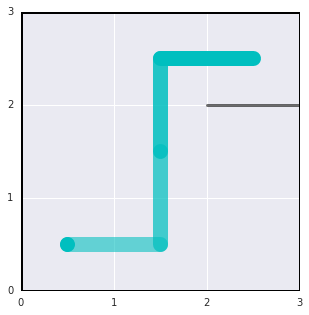

In [35]:
def solve_quantum_maze(size=3, max_steps=10000000):
    dirs = [(1, 0), (0, 1), (-1, 0), (0, -1)]
    # Add borders to initial set of edges:
    walls = set()
    for i in range(size):
        walls.add(((0, i), (0, i+1)))
        walls.add(((size, i), (size, i+1)))
        walls.add(((i, 0), (i+1, 0)))
        walls.add(((i, size), (i+1, size)))
    start = State(pos=(0,0), walls=tuple(sorted(walls)), size=size)
    goal = (size - 1, size - 1)
    queue = deque([start])
    parents = {}
    parents[start] = None
    for i_step in range(max_steps):
        if not queue:
            print('No solution exists.')
            return
        next_layer = []
        state = queue.popleft()
        if state.pos == goal:
            return get_path(state, parents)
        for direction in dirs:
            next_state = create_next_state(state, direction)
            if not next_state or next_state in parents:
                continue
            queue.append(next_state)
            parents[next_state] = state
    print('Step limit exceeded.')
    
def get_path(state, parents):
    backpath = []
    while state:
        backpath.append(state)
        state = parents[state]
    return list(reversed(backpath))

draw_solution(solve_quantum_maze(size=3))

It takes a few minutes to compute already for size=10.

In [29]:
solution5 = solve_quantum_maze(size=5)
solution6 = solve_quantum_maze(size=6)
solution7 = solve_quantum_maze(size=7)
solution8 = solve_quantum_maze(size=8)
solution9 = solve_quantum_maze(size=9)
solution10 = solve_quantum_maze(size=10)

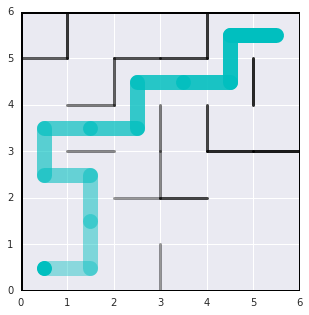

In [47]:
draw_solution(solution6)

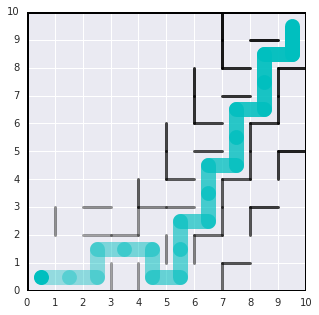

In [40]:
draw_solution(solution10)

## Animation

In [28]:
# # Demo of interactive widgets (works only inside jupyter notebook), requires matplotlib >= 2.0 (!)
# def show_solution_step(step):
#     # TODO: setting to only show a single plot in a cell?
#     return draw_state(steps[step])
# step = widgets.IntSlider(value=0, min=0, max=len(steps)-1, description='step')
# widgets.interact(show_solution_step, step=step)

In [48]:
def save_images(steps):
    plt.ioff()
    os.makedirs('img', exist_ok=True)
    digits = len(str(len(steps)))
    path_tplt = 'img/maze-{{i:0{d}d}}.png'.format(d=digits)
    for i, step in enumerate(steps, start=1):
        im = draw_state(step)
        path = path_tplt.format(i=i)
        im.save(path)
        plt.close()  # Don't draw steps in the notebook.
        
def create_animation(steps):
    save_images(steps)
    size = steps[0].size
    ! cd img; \
        convert -delay 60 -loop 0 maze-*.png maze-{size}.gif; \
        rm maze-*.png
    # Hack to increase a pause between loops.
    # Source: http://www.imagemagick.org/discourse-server/viewtopic.php?t=16876.
    ! cd img; convert maze-{size}.gif \( +clone -set delay 200 \) +swap +delete maze-{size}.gif
    
create_animation(solution10)

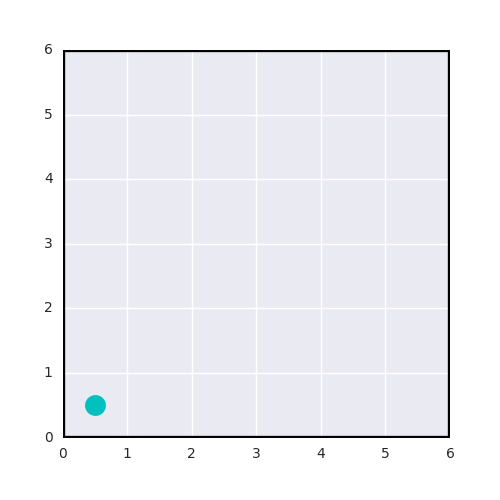

In [206]:
# Currently the Image function do not accept files with gif extension.
# (It works when the file is renamed to end with ".png")
#Image(filename='img/maze-6.gif.png')

# The following works, but is inconvenient for debugging, because browser caches the result
#HTML('<img src="img/maze-6.gif">')

# The last option is... just too long.
with open('img/maze-6.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))

Or we can use animation class provided by Matplotlib,
which allows to generate and embedd a video easily
(without the need to create images first).

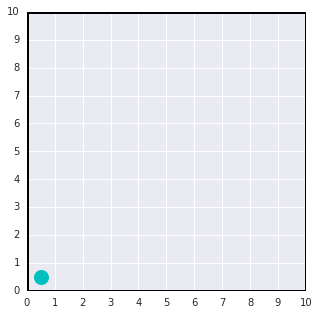

In [50]:
im = VectorImage()
animate = lambda i: draw_state(solution10[i], im=im)
animation = matplotlib.animation.FuncAnimation(
    im.fig, animate, frames=len(solution10),
    interval=500, repeat_delay=1000)
HTML(animation.to_html5_video())